In [1]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import optimizers
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
from tensorflow.keras.optimizers.experimental import AdamW
from sklearn.model_selection import KFold, StratifiedKFold

In [2]:
data_path = 'data.csv'
df = pd.read_csv(data_path)

In [3]:
df.shape

(5527, 13)

In [4]:
dummy_fields = ["Layer-1","Layer-2"]

for each in dummy_fields:
    dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
    df = pd.concat([df,dummies], axis=1)

In [5]:
fields_to_drop = ["Layer-1","Layer-2"]
df = df.drop(fields_to_drop, axis=1)

In [6]:
df.head()

,Ana-1,Ana-2,Thickness,WaveLength,Core_Real,CoreImag,TotalPower,CorePower,EffectiveArea,EML,CLoss,Layer-1_AU,Layer-1_Au,Layer-1_Au+Ta2O5,Layer-1_TiO2,Layer-2_Au,Layer-2_TIO2,Layer-2_Ta2O5,Layer-2_TiO2
0,1.33,1.33,40,1500.0,1.4327,-3.380000e-09,5.240000e-10,5.230000e-10,1.940000e-11,19.9,0.12289,0,1,0,0,0,0,0,1
1,1.33,1.33,40,1520.0,1.4322,-4.400000e-09,5.030000e-10,5.010000e-10,1.660000e-11,19.9,0.15782,0,1,0,0,0,0,0,1
2,1.33,1.33,40,1540.0,1.4316,-5.840000e-09,4.960000e-10,4.940000e-10,1.570000e-11,19.9,0.20700,0,1,0,0,0,0,0,1
3,1.33,1.33,40,1560.0,1.4311,-8.070000e-09,4.930000e-10,4.920000e-10,1.650000e-11,19.9,0.28230,0,1,0,0,0,0,0,1
4,1.33,1.33,40,1580.0,1.4305,-1.190000e-08,4.630000e-10,4.620000e-10,1.990000e-11,19.9,0.41038,0,1,0,0,0,0,0,1


In [7]:
for each in df.columns:
  print(each,' '*(20-len(each)), df[each].isnull().values.any())

Ana-1                 False
Ana-2                 False
Thickness             False
WaveLength            False
Core_Real             False
CoreImag              False
TotalPower            False
CorePower             False
EffectiveArea         False
EML                   False
CLoss                 False
Layer-1_AU            False
Layer-1_Au            False
Layer-1_Au+Ta2O5      False
Layer-1_TiO2          False
Layer-2_Au            False
Layer-2_TIO2          False
Layer-2_Ta2O5         False
Layer-2_TiO2          False


In [8]:
tar = ['Core_Real', 'CoreImag', 'TotalPower', 'CorePower','EML', 'CLoss']
# tar = ['CLoss']
x = df[["Layer-1_Au",	"Layer-1_Au+Ta2O5",	"Layer-1_TiO2",	"Layer-2_Au",	"Layer-2_Ta2O5",	"Layer-2_TiO2","Ana-1","Ana-2","Thickness","WaveLength"]]
y = df[tar]

In [9]:
x.head()

,Layer-1_Au,Layer-1_Au+Ta2O5,Layer-1_TiO2,Layer-2_Au,Layer-2_Ta2O5,Layer-2_TiO2,Ana-1,Ana-2,Thickness,WaveLength
0,1,0,0,0,0,1,1.33,1.33,40,1500.0
1,1,0,0,0,0,1,1.33,1.33,40,1520.0
2,1,0,0,0,0,1,1.33,1.33,40,1540.0
3,1,0,0,0,0,1,1.33,1.33,40,1560.0
4,1,0,0,0,0,1,1.33,1.33,40,1580.0


In [10]:
quant_features = tar
scaled_features = {}

for each in quant_features:
    mean, std = y[each].mean(), y[each].std()
    scaled_features[each] = [mean, std]
    y.loc[:, each] = (y[each] - mean)/std 

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5388\3167035514.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[:, each] = (y[each] - mean)/std
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5388\3167035514.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[:, each] = (y[each] - mean)/std
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5388\3167035514.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=44)

In [12]:
keepX = X_test.iloc[0:100,:]
keepY = y_test.iloc[0:100,:]
keepX = keepX.to_numpy()
keepY = keepY.to_numpy()

In [13]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [51]:
from numpy import loadtxt
from tensorflow.keras.models import load_model
 
# load model
model = load_model('folder/model.h5')
# summarize model.
model.summary()
# load dataset

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 256)               2816      
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 6)                 102       
                                                                 
Total params: 46,678
Trainable params: 46,678
Non-trai

35/35 [==============================] - 0s 530us/step
Abs Error : [ 83.39332839  39.12120888  60.25731123  60.04215181 218.05515332
  46.12215422]
ERROR : 0.07640013680618585
Core_Real 0.9844166580363176
CoreImag 0.9950410987779273
TotalPower 0.9940796490087328
CorePower 0.9941307898549693
EML 0.9035047790909768
CLoss 0.9938880010452092


<Figure size 1000x500 with 0 Axes>

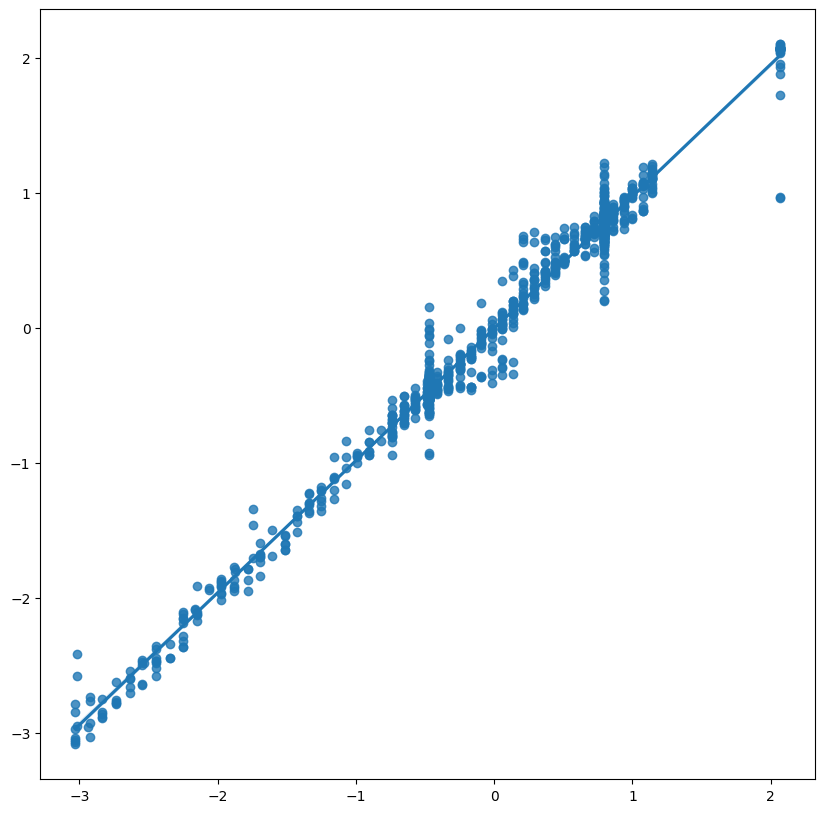

<Figure size 1000x500 with 0 Axes>

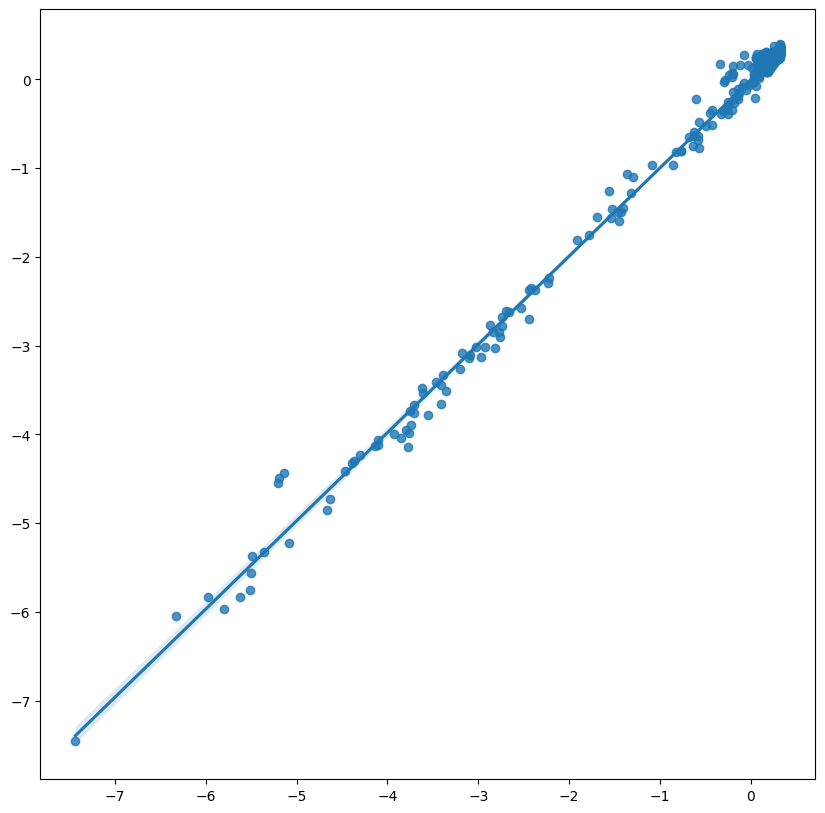

<Figure size 1000x500 with 0 Axes>

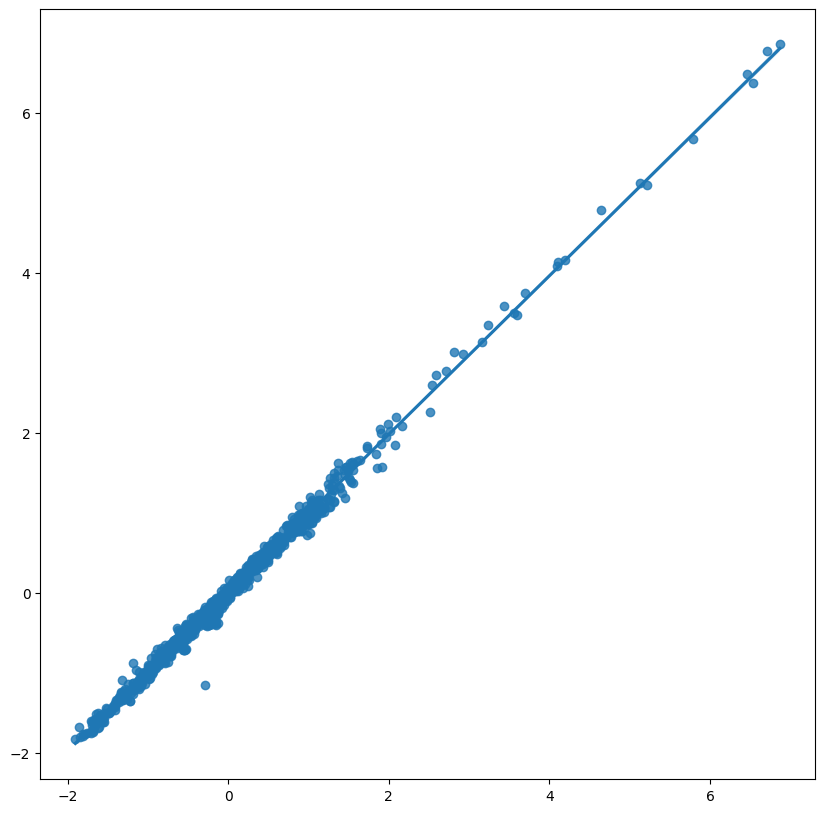

<Figure size 1000x500 with 0 Axes>

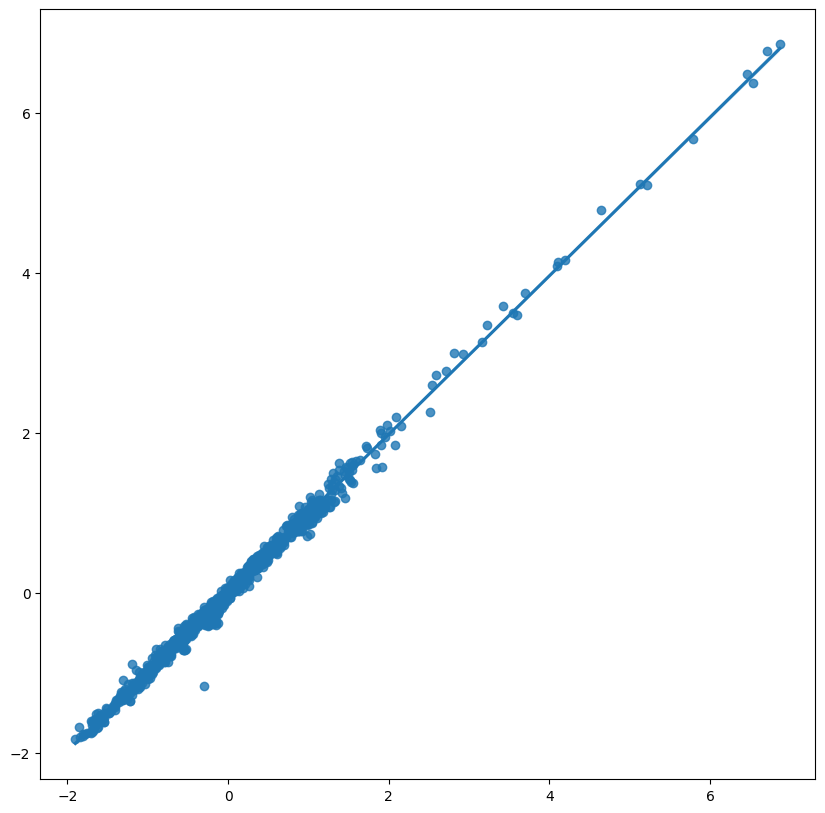

<Figure size 1000x500 with 0 Axes>

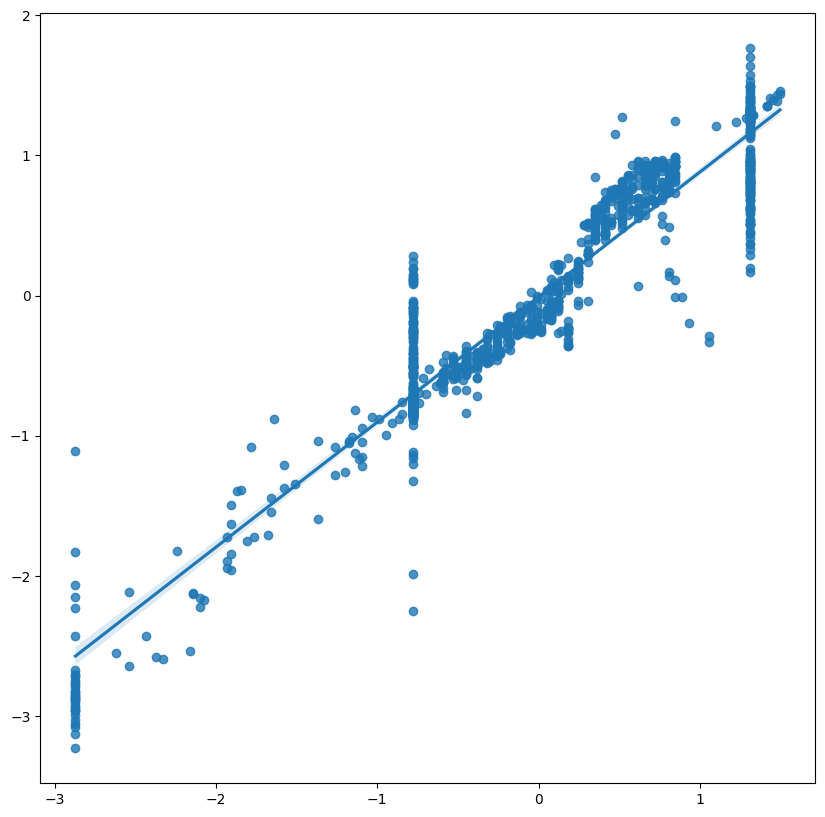

<Figure size 1000x500 with 0 Axes>

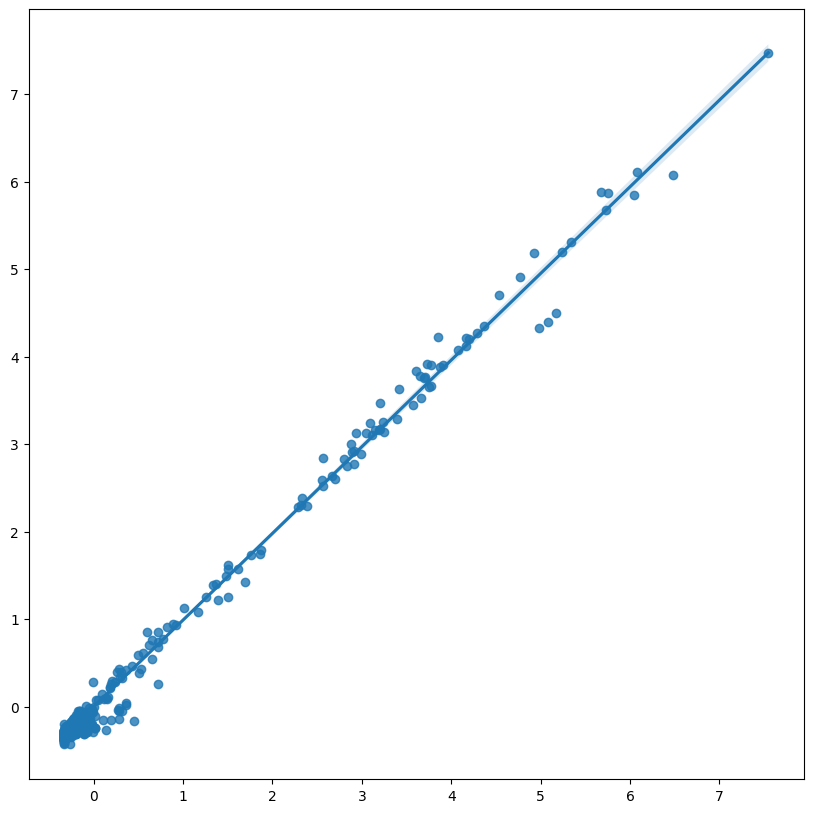

In [52]:
p = model.predict(X_test)
y = y_test
cnt=0
for i in range(len(p)):
#       print(y[i],'\t', pre[i],'\t', abs(y[i] - pre[i]))
      cnt = cnt + abs(y[i] - p[i])
print('Abs Error :', cnt)
print('ERROR :', metrics.mean_absolute_error(y,p))
for l in range(6):
    print(tar[l], metrics.r2_score(y[:,l], p[:,l]))
    fig = plt.figure(figsize=(10,5))
    plt.figure(figsize=(10,10))
    line_plot = sns.regplot(x=y[:,l], y=p[:,l])
    fig = line_plot.get_figure()
    fig.savefig(tar[l]+'.png', bbox_inches='tight', dpi=250,transparent=True)

In [17]:
p = model.predict(keepX)
y = keepY

4/4 [==============================] - 0s 1ms/step


In [35]:
k = 5
for i in p[:,k]:
    print(i)

0.14195317
-0.31497663
-0.29190883
0.0009755492
0.60942256
-0.3377928
-0.29640815
-0.1943244
1.6219925
-0.3103074
-0.32239026
-0.30546665
-0.3020814
-0.28646302
-0.31167224
-0.28841954
-0.21133018
-0.23724625
0.90884435
-0.093972534
-0.2843463
-0.28204495
0.47074533
-0.33681512
-0.3021619
-0.31178892
-0.2896672
-0.19219062
-0.1653578
-0.023463488
-0.3167598
-0.32356942
-0.326923
-0.25167805
-0.3237987
0.08566427
-0.31413043
-0.23445097
7.4688354
-0.3129456
-0.31169546
-0.34512967
-0.30951846
-0.35390925
0.54373133
-0.310394
-0.32931787
-0.14326319
-0.2521381
-0.27134675
-0.1668506
-0.28339666
-0.26208812
-0.29517132
-0.35488632
-0.28686774
-0.15928659
-0.2943593
-0.31438643
-0.4289017
-0.28336316
-0.31591082
-0.2929214
-0.32269055
-0.182342
-0.14823347
-0.16629508
-0.33095416
-0.30979013
4.70048
-0.33172226
-0.28115708
-0.33658254
-0.21607664
-0.2727639
1.2496486
-0.30018872
-0.2571674
3.1369805
-0.30442518
-0.30850345
-0.27436656
-0.31275225
-0.31722486
-0.3015563
2.996169
-0.3206262


In [36]:
for i in y[:,k]:
    print(i)

0.08845639024545844
-0.33229753852886607
-0.3068649851940122
0.0020567779182701362
0.5547198680511133
-0.3294547780762676
-0.33218585865394257
-0.20840902273303583
1.505369421547738
-0.3228047491603677
-0.31823247355384016
-0.31366730484844413
-0.3248563592262921
-0.3159009023469143
-0.3238243356548398
-0.3112814166114419
-0.23119425539640745
-0.27014768813393264
0.8160000117926164
-0.11571472654652236
-0.3086708995351048
-0.29620970985471906
0.42976531708555865
-0.330297453496145
-0.31843908132244864
-0.299529647954718
-0.31369649390666277
-0.2538830372587087
-0.12947165659391838
-0.019060871158175393
-0.32765267100363826
-0.32986088671235314
-0.33379492706276664
-0.25561915167797417
-0.32913293698216983
0.15353529917815845
-0.3174898023855988
-0.2792724415509786
7.547504472807191
-0.32460685623299707
-0.24115153151742855
-0.3255206006641894
-0.33379247518187627
-0.33361333050978303
0.6494700892078095
-0.3143414451843461
-0.3292174583420551
-0.17368165798977522
-0.22313046079113485
-0